# L-DED Audiovisual Fusion 

Author: Chen Lequn.
Created on 01 Feb 2023.

- Material： Maraging Steel 300
- Process: Robotic Llser-directed energy deposition
- Experiment number (single bead wall samples): 21-26
- Recorded data: position, veolocity, coaxial melt pool images, acoustic data
- Defect generated: keyhole pores, cracks, defect-free

### Notebook 3: benchmarking on audio dataset

- Performances for various deep learning models (VGG, GoogleNet, ResNet, LeNet, etc.) are evaluated and benchmarked on the coaxial melt pool image dataset.
- Best performance will guide subsequent multimodal fusion network development.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.multiprocessing as mp

import torchvision
import torchaudio
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

# audio signal augmentation packages
import audiomentations
import torch_audiomentations
from audiomentations import Compose, AddGaussianNoise
from audiomentations import Normalize
# from audiomentations import BandPassFilter, Gain, HighPassFilter

from torch_audiomentations import PolarityInversion

import os
import argparse
from torch.utils.data import Subset
import pandas as pd
import numpy as np

# Scikit learn
#from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle, resample, class_weight
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import label_binarize

from audio_models import * 
from multimodaldataset import MultimodalDataset, LDEDAudioDataset, LDEDVisionDataset
from utils import *
from train_utils import train_single_epoch, test_single_epoch, training_loop

## plot
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.pyplot import gca
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
%matplotlib inline
import seaborn as sns
from itertools import cycle
import itertools

In [2]:
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'defect classification', 'class_name_v2','train_audio')
os.makedirs(IMAGE_PATH, exist_ok=True)

model_path = os.path.join(PROJECT_ROOT_DIR, "trained_models", 'defect classification', 'class_name_v2', 'audio_model')
os.makedirs(model_path, exist_ok=True)

Multimodal_dataset_PATH = "/home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset"
Dataset_path = os.path.join(Multimodal_dataset_PATH, f'25Hz')

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

In [3]:
classes = ('Defect-free', 'Defective', 'Laser-off')
# classes = ('Laser-off', 'Defect-free', 'Cracks', "Keyhole pores")
SAMPLE_RATE = 44100
LEARNING_RATE = 0.00001
BATCH_SIZE = 32
EPOCHS = 200

### Use GPU if possible

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")
mp.set_start_method(method='forkserver', force=True)

Using cuda


### Annotation file

- Vision acoustic spatio-temporal registration has been done in our previous work. 
- Each frame (timestamp) corresponds to a robot TCP position.
- The duration for each frame is 0.01 seconds (sampling freqeuncy 10 Hz.)

In [5]:
# Read the data back from the HDF5 file into a new DataFrame
df_multimodal = pd.read_hdf(os.path.join(Dataset_path, 'spatiotemporal_fused_multimodal.h5'), key='df')
df_multimodal = df_multimodal.dropna(subset=['class_name'])

df_multimodal

,sample index,Time_Stamps,audio_file_name,image_file_name,class_name,class_name_v2,Layer number,Sample number,rms_energy,amplitude_envelope_mean,...,center_y,contour_area,contour_length,X,Y,Z,Vx,Vy,Vz,Speed
0,1,0.00,sample_21_1.wav,sample_21_1.jpg,Laser-off,Laser-off,1.0,21,0.009018,0.003034,...,0.000000,0.0,0.000000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000
1,2,0.04,sample_21_2.wav,sample_21_2.jpg,Defect-free,Defect-free,1.0,21,0.019286,0.012109,...,239.000000,305442.0,2234.000000,0.000,-0.000,0.001,-0.074,-0.074,0.000,0.105
2,3,0.08,sample_21_3.wav,sample_21_3.jpg,Defect-free,Defect-free,1.0,21,0.019593,0.015114,...,239.000000,305442.0,2234.000000,-0.010,0.015,-0.007,-0.051,0.026,-0.051,0.077
3,4,0.12,sample_21_4.wav,sample_21_4.jpg,Defect-free,Defect-free,1.0,21,0.030937,0.021501,...,230.264496,291865.5,2279.781744,-0.007,0.016,0.010,0.173,-0.222,2.520,2.536
4,5,0.16,sample_21_5.wav,sample_21_5.jpg,Defect-free,Defect-free,1.0,21,0.038329,0.029851,...,229.109962,281970.0,2407.847760,-0.111,0.123,-0.057,-1.864,1.662,-2.468,3.511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48461,10982,439.24,sample_26_10982.wav,sample_26_10982.jpg,Laser-off,Laser-off,NaN,26,0.011000,0.009066,...,0.000000,0.0,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080
48462,10983,439.28,sample_26_10983.wav,sample_26_10983.jpg,Laser-off,Laser-off,NaN,26,0.008347,0.006188,...,0.000000,0.0,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080
48463,10984,439.32,sample_26_10984.wav,sample_26_10984.jpg,Laser-off,Laser-off,NaN,26,0.011081,0.007763,...,0.000000,0.0,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080
48464,10985,439.36,sample_26_10985.wav,sample_26_10985.jpg,Laser-off,Laser-off,NaN,26,0.011044,0.007960,...,0.000000,0.0,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080


In [6]:
# Get the labels and count the number of samples for each class
labels = df_multimodal['class_name_v2'].values
label_counts = np.unique(labels, return_counts=True)[1]
print (label_counts)

[ 8993  5806 18147]


In [7]:
def get_sample_directories_from_df(df, Dataset_path):
    # Extract unique sample numbers from the DataFrame
    unique_sample_numbers = df['Sample number'].unique()
    
    # Generate the full paths for image and audio directories
    image_directories = [os.path.join(Dataset_path, str(sample_number), 'images') for sample_number in unique_sample_numbers]
    audio_directories = [os.path.join(Dataset_path, str(sample_number), 'raw_audio') for sample_number in unique_sample_numbers]
    
    return image_directories, audio_directories

samples = [21, 22, 23, 24, 26, 32]
image_directories, audio_directories = get_sample_directories_from_df(df_multimodal, Dataset_path)

### Basline accuracy
The baseline accuracy in this multi-class classificiation problem is **55%**, which is the accuracy of trivially predicting the most-frequent class (classify to the largest class– in other words).

In [8]:
### Get the percentage distribution of each category
round(df_multimodal.groupby('class_name_v2')["class_name_v2"].count()/df_multimodal.shape[0]*100, 1)

class_name_v2
Defect-free    27.3
Defective      17.6
Laser-off      55.1
Name: class_name_v2, dtype: float64

Saving figure dataset_distribution.png


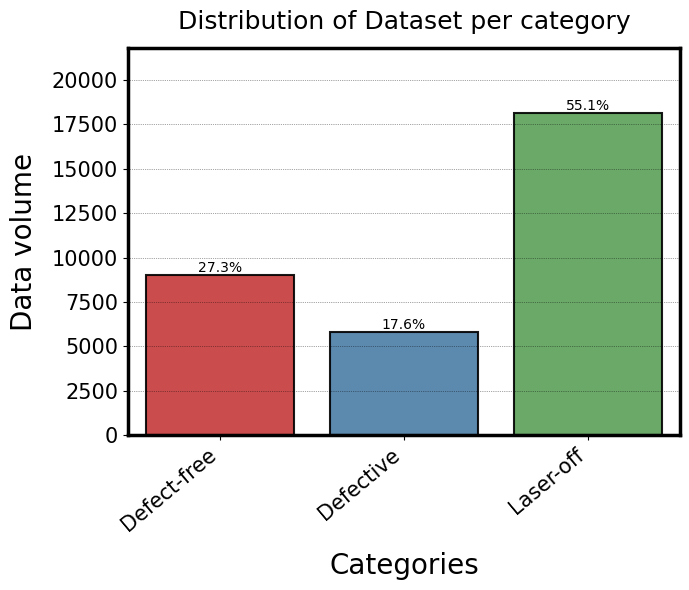

In [9]:
filename = 'dataset_distribution'
plot_data_distribution(df_multimodal, 'class_name_v2', 
                       'Distribution of Dataset per category', filename)
save_fig(f"{filename}.png")

## Preparing Dataset and DataLoader

#### Data Augmentation methods

In [11]:
# #------ transformation------
# # instantiating our dataset object and create data loader
# mel_spectrogram = torchaudio.transforms.MelSpectrogram(
#     sample_rate=SAMPLE_RATE,
#     n_fft=512,
#     hop_length=256,
#     n_mels=32
# )

# MFCCs = torchaudio.transforms.MFCC(sample_rate=SAMPLE_RATE,n_mfcc=20)



# augmentation = Compose(
#     [
#        AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.002, p=0.5),
#        # HighPassFilter(min_cutoff_freq=1000, max_cutoff_freq=21000, p=0.5),
#        BandPassFilter(min_center_freq=1000, max_center_freq=21000, p=0.5),
#        # Gain(min_gain_in_db = -2, max_gain_in_db = 2, p=0.5),
#        Normalize(p=0.5)
#     ]
# )


# # Initialize augmentation callable
# apply_augmentation = Compose(
#     transforms=[
#         # Gain(
#         #     min_gain_in_db=-15.0,
#         #     max_gain_in_db=5.0,
#         #     p=0.5,
#         # ),
#         PolarityInversion(p=0.5)
#     ]
# )

# train_transform = transforms.Compose([
#     augmentation,
#     apply_augmentation,
#     # torchaudio.transforms.TimeMasking(time_mask_param=20, p=0.5),  # apply time masking with probability of 0.5
#     # torchaudio.transforms.FrequencyMasking(freq_mask_param=20),  # apply time masking with probability of 0.5
#     torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=512, hop_length=256, n_mels=32),  # compute Mel-frequency cepstral coefficients (MFCCs)
# ])


In [12]:
#------ data loader------
# create the dataset for all samples
audiodataset = LDEDAudioDataset(df_multimodal,
                                audio_directories,
                                samples,
                                mel_spectrogram,
                                # MFCCs,
                                # spectral_centroid,
                                SAMPLE_RATE,
                                device)
print ("length of the total dataset:" + str(len(audiodataset)))

length of the total dataset:32946


## Train Val Test dataset 

In [13]:
%store -r train_indices
%store -r val_indices
%store -r test_indices

In [14]:
# Create train, val, and test datasets for deep learning models
train_annotations = df_multimodal.iloc[train_indices, :]
val_annotations = df_multimodal.iloc[val_indices, :]
test_annotations = df_multimodal.iloc[test_indices, :]

train_dataset = LDEDAudioDataset(train_annotations, audio_directories, samples, mel_spectrogram, SAMPLE_RATE, device=device)
val_dataset = LDEDAudioDataset(val_annotations, audio_directories, samples, mel_spectrogram, SAMPLE_RATE, device=device)
test_dataset = LDEDAudioDataset(test_annotations, audio_directories, samples, mel_spectrogram, SAMPLE_RATE, device=device)

### Create DataLoader using the dataset

In [15]:
# # Create train and val dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print("length of the train dataset:" +  str(len(train_dataloader.dataset)))
print("length of the val dataset:" +  str(len(val_dataloader.dataset)))
print("length of the test dataset:" +  str(len(test_dataloader.dataset)))

length of the train dataset:26356
length of the val dataset:3295
length of the test dataset:3295


### Hyperparameter tuning

In [17]:
# Importing required libraries
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from tqdm import tqdm
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Objective function
def objective(params):
    # Initialize your model
    net = MFCCCNN(dropout_rate=params['dropout_rate'])
    net = net.to(device)
    
    # Loss and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=params['learning_rate'], momentum=params['momentum'], weight_decay=params['regularization'])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    # Create DataLoaders
    BATCH_SIZE = int(params['batch_size'])
    
     # Use a subset of the dataset for hyperparameter tuning
    n_train = int(len(train_dataset) * 0.2)  # 20% of the training set
    n_val = int(len(val_dataset) * 0.1)  # 10% of the validation set
    
    subset_train_dataset = torch.utils.data.Subset(train_dataset, np.random.choice(len(train_dataset), n_train, replace=False))
    subset_val_dataset = torch.utils.data.Subset(val_dataset, np.random.choice(len(val_dataset), n_val, replace=False))
    
    train_dataloader = DataLoader(subset_train_dataset, batch_size=int(params['batch_size']), shuffle=True, num_workers=4)
    val_dataloader = DataLoader(subset_val_dataset, batch_size=int(params['batch_size']), shuffle=False, num_workers=4)
    
    
    # Training loop
    _, _, (train_losses, valid_losses, train_accuracy, valid_accuracy) = training_loop(
        model=net, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        train_loader=train_dataloader, 
        valid_loader=val_dataloader, 
        epochs=5,  # adjust this
        scheduler=scheduler,
        device=device, 
        print_every=1,
        mode="single_model"
    )
    
    min_valid_loss = min(valid_losses)
    
    return {'loss': min_valid_loss, 'status': STATUS_OK}

# Define hyperparameter space
space = {
    'batch_size': hp.choice('batch_size', [32, 64, 128]),
    'dropout_rate': hp.uniform('dropout_rate', 0, 0.5),
    'learning_rate': hp.loguniform('learning_rate', -7, -2),
    'momentum': hp.uniform('momentum', 0.7, 0.99),
    'regularization': hp.choice('regularization', [1e-3, 1e-4, 1e-5])
}

# Run optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

print("Best hyperparameters found: ", best)

                                                                                
Epoch: 0
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

Epoch 0:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/83 [00:07<?, ?it/s, loss=1.1, accuracy=53.1]

Epoch 0:   1%|1         | 1/83 [00:07<10:12,  7.47s/it, loss=1.1, accuracy=53.1]

Epoch 0:   1%|1         | 1/83 [00:07<10:12,  7.47s/it, loss=1.1, accuracy=53.1]

Epoch 0:   1%|1         | 1/83 [00:07<10:12,  7.47s/it, loss=1.1, accuracy=52.1]

Epoch 0:   1%|1         | 1/83 [00:08<10:12,  7.47s/it, loss=1.1, accuracy=54.3]

Epoch 0:   5%|4         | 4/83 [00:08<02:22,  1.81s/it, loss=1.1, accuracy=54.3]

Epoch 0:   5%|4         | 4/83 [00:08<02:22,  1.81s/it, loss=1.09, accuracy=55.6]

Epoch 0:   5%|4         | 4/83 [00:08<02:22,  1.81s/it, loss=1.1, accuracy=56.5] 

Epoch 0:   5%|4         | 4/83 [00:08<02:22,  1.81s/it, loss=1.1, accuracy=56]  

Epoch 0:   5%|4         | 4/83 [00:08<02:22,  1.81s/it, loss=1.1, accuracy=55.3]

Epoch 0:   5%|4         | 4/83 [00:09<02:22,  1.81s/it, loss=1.1, accuracy=56.4]

Epoch 0:   5%|4         | 4/83 [00:09<02:22,  1.81s/it,

18:15:05 --- Epoch: 0	Train loss: 1.0739	Valid loss: 0.0191	Train accuracy: 61.39	Valid accuracy: 65.35
                                                                                
Epoch: 1
  0%|                                    | 0/10 [00:18<?, ?trial/s, best loss=?]

Epoch 1:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/83 [00:07<?, ?it/s, loss=1.06, accuracy=60.9]

Epoch 1:   1%|1         | 1/83 [00:07<09:48,  7.17s/it, loss=1.06, accuracy=60.9]

Epoch 1:   1%|1         | 1/83 [00:07<09:48,  7.17s/it, loss=1.06, accuracy=58.6]

Epoch 1:   1%|1         | 1/83 [00:07<09:48,  7.17s/it, loss=1.04, accuracy=64.1]

Epoch 1:   4%|3         | 3/83 [00:07<02:36,  1.96s/it, loss=1.04, accuracy=64.1]

Epoch 1:   4%|3         | 3/83 [00:08<02:36,  1.96s/it, loss=1.04, accuracy=64.1]

Epoch 1:   5%|4         | 4/83 [00:08<02:18,  1.75s/it, loss=1.04, accuracy=64.1]

Epoch 1:   5%|4         | 4/83 [00:08<02:18,  1.75s/it, loss=1.04, accuracy=65]  

Epoch 1:   5%|4         | 4/83 [00:08<02:18,  1.75s/it, loss=1.04, accuracy=65.1]

Epoch 1:   5%|4         | 4/83 [00:08<02:18,  1.75s/it, loss=1.04, accuracy=65.4]

Epoch 1:   5%|4         | 4/83 [00:08<02:18,  1.75s/it, loss=1.04, accuracy=64.6]

Epoch 1:   5%|4         | 4/83 [00:08<02:18,  

18:15:25 --- Epoch: 1	Train loss: 0.9835	Valid loss: 0.0170	Train accuracy: 64.01	Valid accuracy: 67.48
                                                                                
Epoch: 2
  0%|                                    | 0/10 [00:38<?, ?trial/s, best loss=?]

Epoch 2:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/83 [00:07<?, ?it/s, loss=0.9, accuracy=67.2]

Epoch 2:   1%|1         | 1/83 [00:07<10:07,  7.40s/it, loss=0.9, accuracy=67.2]

Epoch 2:   1%|1         | 1/83 [00:07<10:07,  7.40s/it, loss=0.914, accuracy=64.8]

Epoch 2:   1%|1         | 1/83 [00:07<10:07,  7.40s/it, loss=0.902, accuracy=68.2]

Epoch 2:   1%|1         | 1/83 [00:09<10:07,  7.40s/it, loss=0.902, accuracy=68.8]

Epoch 2:   5%|4         | 4/83 [00:09<02:26,  1.85s/it, loss=0.902, accuracy=68.8]

Epoch 2:   5%|4         | 4/83 [00:09<02:26,  1.85s/it, loss=0.911, accuracy=67.8]

Epoch 2:   5%|4         | 4/83 [00:09<02:26,  1.85s/it, loss=0.902, accuracy=68.5]

Epoch 2:   5%|4         | 4/83 [00:09<02:26,  1.85s/it, loss=0.91, accuracy=67]   

Epoch 2:   5%|4         | 4/83 [00:09<02:26,  1.85s/it, loss=0.911, accuracy=67.4]

Epoch 2:   5%|4         | 4/83 [00:09<02:26,  1.85s/it, loss=0.905, accuracy=67.9]

Epoch 2:   5%|4         | 4/83 [00:09<0

18:15:44 --- Epoch: 2	Train loss: 0.8879	Valid loss: 0.0159	Train accuracy: 67.52	Valid accuracy: 71.43
                                                                                
Epoch: 3
  0%|                                    | 0/10 [00:57<?, ?trial/s, best loss=?]

Epoch 3:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/83 [00:07<?, ?it/s, loss=0.854, accuracy=71.9]

Epoch 3:   1%|1         | 1/83 [00:07<10:36,  7.76s/it, loss=0.854, accuracy=71.9]

Epoch 3:   1%|1         | 1/83 [00:07<10:36,  7.76s/it, loss=0.864, accuracy=71.1]

Epoch 3:   1%|1         | 1/83 [00:07<10:36,  7.76s/it, loss=0.856, accuracy=71.4]

Epoch 3:   4%|3         | 3/83 [00:07<02:46,  2.08s/it, loss=0.856, accuracy=71.4]

Epoch 3:   4%|3         | 3/83 [00:09<02:46,  2.08s/it, loss=0.854, accuracy=71.5]

Epoch 3:   5%|4         | 4/83 [00:09<02:20,  1.78s/it, loss=0.854, accuracy=71.5]

Epoch 3:   5%|4         | 4/83 [00:09<02:20,  1.78s/it, loss=0.853, accuracy=71.6]

Epoch 3:   5%|4         | 4/83 [00:09<02:20,  1.78s/it, loss=0.859, accuracy=70.8]

Epoch 3:   5%|4         | 4/83 [00:09<02:20,  1.78s/it, loss=0.86, accuracy=71.2] 

Epoch 3:   5%|4         | 4/83 [00:09<02:20,  1.78s/it, loss=0.87, accuracy=69.3]

Epoch 3:   5%|4         | 4/83 [00:0

18:16:04 --- Epoch: 3	Train loss: 0.8470	Valid loss: 0.0153	Train accuracy: 70.71	Valid accuracy: 74.47
                                                                                
Epoch: 4
  0%|                                    | 0/10 [01:17<?, ?trial/s, best loss=?]

Epoch 4:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/83 [00:07<?, ?it/s, loss=0.811, accuracy=75]

Epoch 4:   1%|1         | 1/83 [00:07<10:06,  7.39s/it, loss=0.811, accuracy=75]

Epoch 4:   1%|1         | 1/83 [00:07<10:06,  7.39s/it, loss=0.818, accuracy=73.4]

Epoch 4:   2%|2         | 2/83 [00:07<04:14,  3.14s/it, loss=0.818, accuracy=73.4]

Epoch 4:   2%|2         | 2/83 [00:07<04:14,  3.14s/it, loss=0.823, accuracy=72.4]

Epoch 4:   4%|3         | 3/83 [00:07<02:27,  1.85s/it, loss=0.823, accuracy=72.4]

Epoch 4:   4%|3         | 3/83 [00:09<02:27,  1.85s/it, loss=0.836, accuracy=70.7]

Epoch 4:   5%|4         | 4/83 [00:09<02:03,  1.57s/it, loss=0.836, accuracy=70.7]

Epoch 4:   5%|4         | 4/83 [00:09<02:03,  1.57s/it, loss=0.854, accuracy=68.4]

Epoch 4:   5%|4         | 4/83 [00:09<02:03,  1.57s/it, loss=0.854, accuracy=68.5]

Epoch 4:   5%|4         | 4/83 [00:09<02:03,  1.57s/it, loss=0.856, accuracy=68.5]

Epoch 4:   5%|4         | 4/83 [00:09<0

18:16:23 --- Epoch: 4	Train loss: 0.8244	Valid loss: 0.0150	Train accuracy: 72.62	Valid accuracy: 75.99
                                                                                
Epoch: 0
 10%|▊       | 1/10 [01:36<14:29, 96.62s/trial, best loss: 0.015024483566226205]

Epoch 0:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/83 [00:07<?, ?it/s, loss=1.09, accuracy=50]

Epoch 0:   1%|1         | 1/83 [00:07<10:01,  7.34s/it, loss=1.09, accuracy=50]

Epoch 0:   1%|1         | 1/83 [00:07<10:01,  7.34s/it, loss=1.09, accuracy=49.2]

Epoch 0:   1%|1         | 1/83 [00:07<10:01,  7.34s/it, loss=1.09, accuracy=51]  

Epoch 0:   4%|3         | 3/83 [00:07<02:38,  1.98s/it, loss=1.09, accuracy=51]

Epoch 0:   4%|3         | 3/83 [00:07<03:25,  2.56s/it, loss=1.09, accuracy=51]


 10%|▋      | 1/10 [01:44<15:38, 104.33s/trial, best loss: 0.015024483566226205]



KeyboardInterrupt



## Training the model

In [ ]:
resume = False
start_epoch = 0
best_acc = 0

In [ ]:
# -----Model---------------
print('==> Building model..')

net = MFCCCNN() 

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    print ("--- Using CUDA ---")

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

loss_fn = nn.CrossEntropyLoss()
# Note: weight_decay in pytorch is L2 regularization
# optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE,
#                     momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


# for epoch in range(start_epoch, start_epoch+EPOCHS):
    # train_single_epoch(net, epoch, train_dataloader, loss_fn, optimizer, device)
    # test_single_epoch(net, epoch, val_dataloader, loss_fn, device)
    # scheduler.step()

model, optimizer, (train_losses, valid_losses, train_accuracy, valid_accuracy) = training_loop(net, loss_fn, optimizer, train_dataloader, val_dataloader, EPOCHS, scheduler, device)

In [ ]:
valid_accuracy

In [ ]:
loss_acc_plot(train_losses, valid_losses, train_accuracy, valid_accuracy, 25, "Initial Training",
              interval=5, yloss_limit1=0, yloss_limit2=0.3, yacc_limit1=30, yacc_limit2=100)

save_fig ("train_lost_curve_audio")

In [ ]:
get_accuracy(model, val_dataloader, device)

In [ ]:
test_accuracy_mean, test_accuracy_std, auc_mean, auc_std = model_evaluation(model, val_dataloader, classes, device, classifier_name = "MFCC-CNN", 
                                                                            signal_type = "raw", seed=0)

save_fig ("ROC_curve (acoustic-based)-raw")

In [ ]:
yt, yp = class_report(model, val_dataloader, device, classes)

In [ ]:
conf_matrix(yt, yp, classes)
save_fig("confusion_matrix(audio_based)-raw")

### Save the trained model into the folder

In [ ]:
# Save the model's state_dict
torch.save(model.state_dict(), os.path.join(model_path, 'trained_audio_MFCC-CNN(raw).pth'))

# Load the trained model to test

In [ ]:
# Initialize your model
model = nn.DataParallel(MFCCCNN())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load the state dictionary
model.load_state_dict(torch.load(os.path.join(model_path, 'trained_audio_MFCC-CNN(raw).pth')))


model.eval()  # Set the model to evaluation mode

### Random testing

In [ ]:
import PIL.Image

# Load and preprocess the image
sample_number = 32
index = 12600
img_path = os.path.join(Dataset_path, f"{sample_number}/images/sample_{sample_number}_{index}.jpg")
audio_path = os.path.join(Dataset_path, f"{sample_number}/raw_audio/sample_{sample_number}_{index}.wav")
input_image = PIL.Image.open(img_path).convert('L')  
# apply transform
waveform, sample_rate = torchaudio.load(audio_path)
waveform = waveform.to(device)
input_tensor = mel_spectrogram(waveform)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

# Move the input to the GPU if available
input_batch = input_batch.to(device)

# Make the prediction
with torch.no_grad():
    output = model(input_batch)

# The output has unnormalized scores. To get the label, use argmax to get the index of the maximum score
_, predicted_label_index = torch.max(output, 1)


print(f"Predicted label index: {predicted_label_index.item()}")


# (1) Map the predicted index to the actual class name
index_to_class = {
    0: 'Laser-off',
    1: 'Defect-free',
    2: 'Defective'
}

predicted_class_name = index_to_class[predicted_label_index.item()]
print(f"Predicted class name: {predicted_class_name}")

# (2) Display the image and print the ground truth label
try:
    ground_truth_label = df_multimodal.loc[
        (df_multimodal['Sample number'] == sample_number) & 
        (df_multimodal['image_file_name'] == f"sample_{sample_number}_{index}.jpg"), 
        'class_name_v2'
    ].iloc[0]
except IndexError:
    ground_truth_label = "NaN"


# Display the image
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.title(f"Ground Truth: {ground_truth_label}, Prediction: {predicted_class_name}", pad=15)
plt.axis('off')

# Load and plot the audio signal
waveform, sample_rate = torchaudio.load(audio_path)
plt.subplot(1, 2, 2)
plt.plot(waveform.t().numpy())
plt.title('Audio Signal', pad=15)
plt.xlabel('Sample', labelpad=10)
plt.ylabel('Amplitude', labelpad=10)
plt.ylim([-0.1, 0.1])
plt.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()